In [1]:
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


import matplotlib.pyplot as plt
import json

from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras.utils.vis_utils import plot_model

In [2]:
# Read in the data
df = pd.read_csv("Resources/runner_result_runner_result.csv")
df = df.drop(columns="Unnamed: 0")
#df

In [3]:
# Convert categorical features to numerical
weatherCondition = pd.get_dummies(df.weatherCondition, sparse=True)
trackCondition = pd.get_dummies(df.trackCondition, sparse=True)
#meetingName = pd.get_dummies(df.meetingName, sparse=True)
runnerName = pd.get_dummies(df.runnerName, sparse=True)
raceClassConditions = pd.get_dummies(df.raceClassConditions, sparse=True)


In [4]:
# Initialize the encoder for ordinally meaninful variables
label_encoder = LabelEncoder()

# Fit and transform the label
df['runnerNumber_encoded'] = label_encoder.fit_transform(df['runnerNumber'])
df['raceDistance_encoded'] = label_encoder.fit_transform(df['raceDistance'])



In [5]:
# Combine the features of interest into a dataframe
X = pd.concat([weatherCondition,
               trackCondition,
               #meetingName,
               runnerName,
               raceClassConditions,
               df.raceDistance_encoded,
               df.finishingPosition,
               df.runnerNumber_encoded
              ],axis=1)

print(f"Shape of feature vector before cleaning: {X.size}")
# Drop any nans (maybe check why they are there)
X = X.dropna()
print(f"Shape of feature vector after cleaning: {X.size}")

X.columns = X.columns.astype(str)

Shape of feature vector before cleaning: 116766552
Shape of feature vector after cleaning: 115296788


In [6]:
# Scale the data
scaled_data = StandardScaler().fit_transform(X)


/Users/darcy5d/miniforge3/envs/tensor/lib/python3.8/site-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/darcy5d/miniforge3/envs/tensor/lib/python3.8/site-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [7]:
k = list(range(1, 20))
inertia = []
for i in k:
    model = KMeans(n_clusters=i, random_state=0,n_init='auto')
    model.fit(scaled_data)
    inertia.append(model.inertia_)
    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k,"inertia": inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

In [8]:
elbow_plot = df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)
elbow_plot

:Curve   [k]   (inertia)

In [9]:
# Convert finishingPosition to binary: 1 if the horse placed (1-4), 0 otherwise
X['finishingPosition'] = X['finishingPosition'].apply(lambda x: 1 if 1.0 <= x <= 3.0 else 0)


In [10]:
from sklearn.model_selection import train_test_split

# Features and target variable
y = X['finishingPosition']
X_features = X.drop('finishingPosition', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=1)

In [11]:
import shutil

# Delete the tuner directory and its contents
tuner_dir = 'my_tuner_dir'
shutil.rmtree(tuner_dir, ignore_errors=True)

In [12]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           activation='relu', input_dim=X_train.shape[1]))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='my_tuner_dir', project_name='my_tuner_project')


In [14]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.7955853939056396

Best val_accuracy So Far: 0.7955853939056396
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_model = tuner.get_best_models(num_models=1)[0]


In [16]:
eval_result = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {eval_result[1]}')


82/82 [==============================] - 0s 3ms/step - loss: 0.5841 - accuracy: 0.7846
Test accuracy: 0.7846449017524719


In [17]:
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 480)               4249920   
                                                                 
 dense_1 (Dense)             (None, 1)                 481       
                                                                 
Total params: 4,250,401
Trainable params: 4,250,401
Non-trainable params: 0
_________________________________________________________________


In [18]:
layer_1_config = best_model.layers[0].get_config()
print(layer_1_config)


{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 8853), 'dtype': 'float32', 'units': 480, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [19]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


{'units': 480}


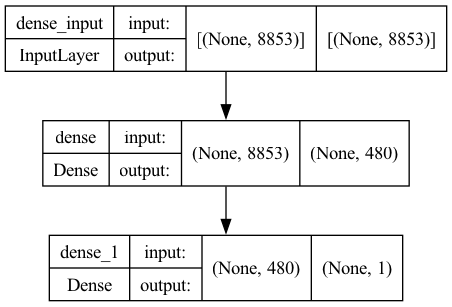

In [20]:
# Visualise the layers of the Keras Sequential Model

plot_model(best_model, to_file='best_model.png', show_shapes=True)


In [ ]:
#Visualise the feature importance

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Create a Random Forest model (you can use your own data and model)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


/Users/darcy5d/miniforge3/envs/tensor/lib/python3.8/site-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the best model loaded and X_test is your test dataset
y_pred = best_model.predict(X_test)

# Convert probabilities to binary labels (e.g., using a threshold of 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
